In [1]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Import the data

In [2]:
df= pd.read_csv('../assets/date_df.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'],inplace=True)

In [4]:
df.promointerval.fillna('N/A', inplace= True)

In [5]:
df['month']= df.index.month
df['quarter']= df.index.quarter

In [6]:
df.drop(columns= 'date', inplace= True)

In [7]:
store= pd.read_csv('../assets/clean_store.csv')

In [8]:
store.drop(columns= 'Unnamed: 0', inplace= True)

In [9]:
store.promointerval.fillna('N/A', inplace= True)

Merging test dataset with store dataset, so that I have the same format as the combination of train and store dataset.

### One hot code 

In [10]:
df= pd.get_dummies(df, columns= ['stateholiday', 'storetype', 'assortment', 'quarter', 'month', 'promointerval'])

In order to use machine learning, categorical features need to be converted to numerical features. Based on the eda notebook, these features have an impact on sales, therefore, I will one hot code these columns.

### Train test split

In [11]:
X= df.drop(axis= 1, columns= ['sales'])
y= df['sales']

In [12]:
ts= TimeSeriesSplit(3)

In [13]:
for train_index, test_index in ts.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Since the dataset is time series data, I need to use time series split because days might be correlated to each other. 

In [14]:
with open('../assets/y_test.pkl','wb+') as f:
     pickle.dump(y_test,f)

#### Scale the data

In [15]:
ss= StandardScaler()
X_train_sc= ss.fit_transform(X_train)
X_test_sc= ss.transform(X_test)

It is important to scale the dataset when using parametric method because every feature is on a different scale. 

### Linear Regression

Linear regression tends to train fast and is easy to interpret. Since the target variable is countinuous, we can use linear regression. I will use Lasso, which uses L1 penalty, so that I can eliminate some features.

###### Lasso

In [16]:
sel_lasso_cv = SelectFromModel(LassoCV(cv= 7))

In [17]:
X_train_sc_lassoed = sel_lasso_cv.fit_transform(X_train_sc, y_train)

In [18]:
included= X_train.columns[sel_lasso_cv.get_support()]

In [19]:
new_df= X[included]

After applying Lasso, 10 features are dropped. The original dataset has 43 features total, but now it goes down to 33. 

###### Export the data

In [20]:
new_df.iloc[:508605, :].to_csv('../assets/new_df1.csv')

In [21]:
new_df.iloc[508605:, :].to_csv('../assets/new_df2.csv')

##### Linear Regression

In [22]:
X= new_df

In [23]:
tss= TimeSeriesSplit(3)

In [24]:
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

##### Gridsearch

In [25]:
pipe = Pipeline([
    ('var_thresh', VarianceThreshold()),
    ('ss', StandardScaler()),
    ('lr', LinearRegression())
])

In [26]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [27]:
params = {
    'var_thresh__threshold': [0, .1,  .5,  .9]
}

In [28]:
gs = GridSearchCV(pipe, params)

In [29]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('var_thresh', VarianceThreshold(threshold=0.0)), ('ss', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var_thresh__threshold': [0, 0.1, 0.5, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [30]:
gs.best_params_

{'var_thresh__threshold': 0}

Variance threshold does not contribute anything to my model in this case.

#### Export the model

In [31]:
with open('../assets/gs_lr.pkl','wb+') as f:
     pickle.dump(gs,f)

### Interpretation

In order to interepret the result of linear regression, we need to find weights on the coeffiicients. 

In [32]:
betas = pd.DataFrame(gs.best_estimator_.named_steps['lr'].coef_, index= new_df.columns)

In [33]:
betas.columns= ['weights']

In [34]:
betas['abs_w'] = betas.weights.abs()

In [35]:
gs.best_estimator_.named_steps['lr'].intercept_

5806.8119849470495

In [36]:
beta_0= gs.best_estimator_.named_steps['lr'].intercept_

In [37]:
weights = betas.sort_values('abs_w', ascending=False)['weights'][:15]
labels = weights.index

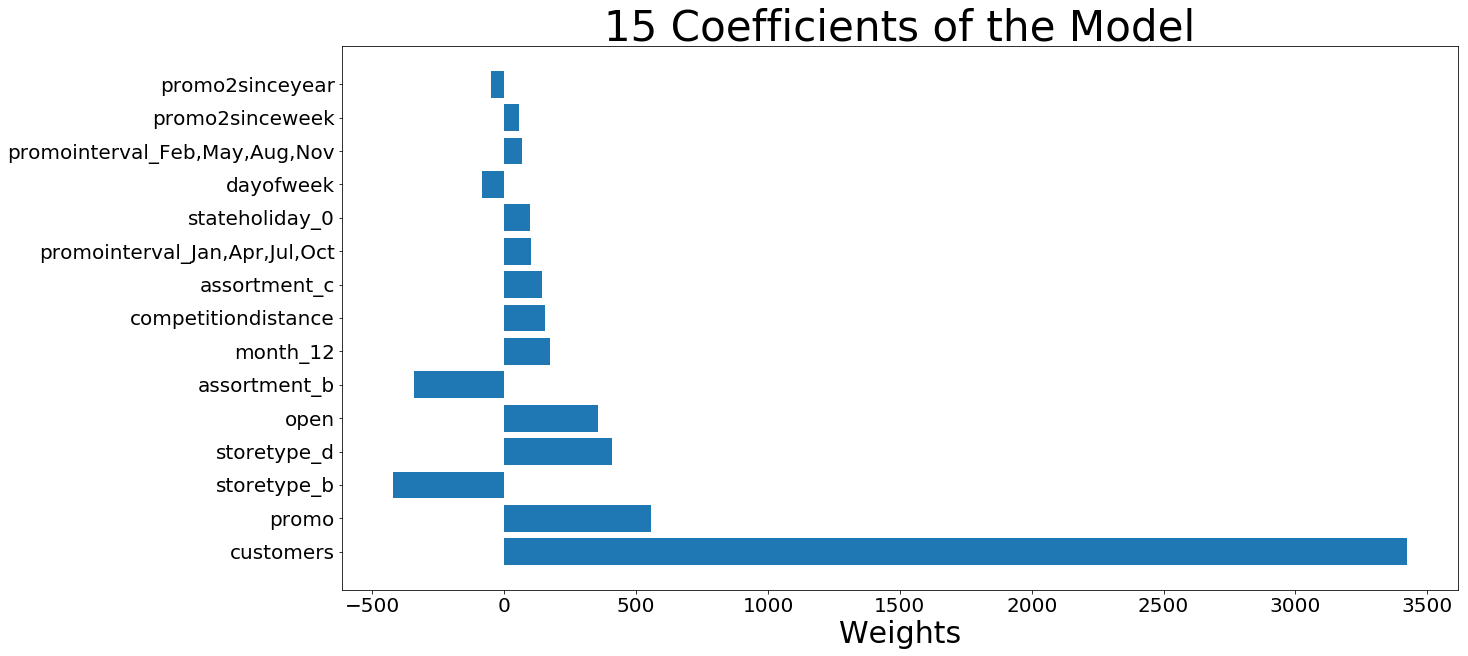

In [38]:
plt.figure(figsize=(20,10))
plt.barh(weights.index, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title('15 Coefficients of the Model', fontsize=42)
plt.savefig('../images/betas');

The intercept of my model is 5806.8, which is closer to the mean of sales of the dataset. Customers have a huge impact on my model. I have two choices in order to fit my model on the test dataset. The problem I face here is test dataset does not contain the customers feature. The first option is I use some sort of regression and try to predict the number of customers in test dataset. If I can predict the number of customers well, it will perform well with the dataset. The second option is using this model for now, and improves it later. I will stick with the second option for now. It also turns out that the existence of promo affects the sales as well.

### Random Forest

In [39]:
rf= RandomForestRegressor()

##### Grid Search

In order to find the best parameters and performance, we can use grid search.

In [40]:
pipe = Pipeline([
    ('rf',RandomForestRegressor(n_jobs= -1,
                                random_state=42,
                                criterion= 'mse'))])

In [41]:
param_grid =  {
    'rf__min_samples_leaf': [6, 10],
    'rf__min_samples_split':[2, 4],
    'rf__n_estimators':[150, 200]
}


In [42]:
gs = GridSearchCV(pipe, param_grid)

In [43]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'rf__min_samples_leaf': [6, 10], 'rf__min_samples_split': [2, 4], 'rf__n_estimators': [150, 200]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [44]:
gs.best_params_

{'rf__min_samples_leaf': 10,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 150}

### Feature importance

In [45]:
feat= pd.DataFrame(gs.best_estimator_.named_steps['rf'].feature_importances_, 
                   X_train.columns, 
                   columns=['importance'])

In [46]:
new_feat= feat.sort_values(ascending= False, by= 'importance')[:7]

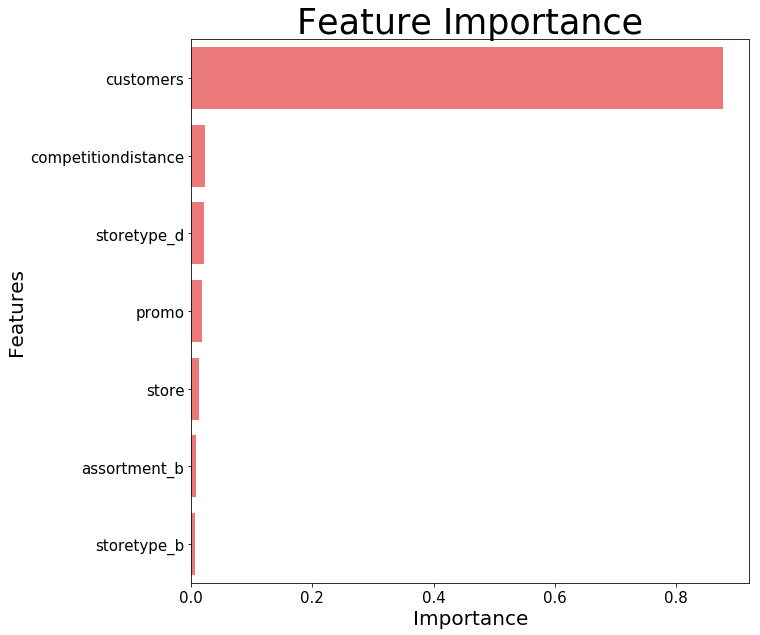

In [47]:
plt.figure(figsize=(10,10))
fig = sns.barplot(x= 'importance', 
            y= new_feat.index, 
            data= new_feat, 
            color='r',
            alpha= 0.6)
plt.title('Feature Importance', fontsize= 35)
plt.xlabel('Importance', fontsize= 20)
plt.xticks(size= 15)
plt.ylabel("Features", fontsize=20)
plt.yticks(size= 15)
plt.savefig('../images/feature');

##### Export the model

In [48]:
with open('../assets/gs_rf.pkl','wb+') as f:
     pickle.dump(gs,f)